In [1]:
import pandas as pd 
import numpy as np 
import sklearn as skl 
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
import time
import warnings
import os
import seaborn as sns # for ploting
from sklearn.metrics import fbeta_score, precision_score, recall_score, confusion_matrix,f1_score
import itertools
import pickle
import matplotlib
from matplotlib import pyplot as plt,style
from multiprocessing import Pool

In [2]:
style.use('ggplot')
np.random.seed(42) 

def plot_confusion_matrix(cm, classes,
                          recall,precision,f2,f1,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=90)
    plt.text(12,0, f" Recall:{recall},\n Precision:{precision},\n F2 Score:{f2},\n F1 Score:{f1}", fontsize=12)
    plt.show()

In [3]:
%%markdown
# Loading the data. 

# Loading the data. 


In [4]:
warnings.simplefilter("ignore", category=DeprecationWarning)

root_feature = '/Volumes/Abhijit-Seagate/Data_iot/Features/required-features-split/google-home-mini-req-april.csv'
root_model='/Users/abhijit/Desktop/GIT_Projects/intl-iot/models_final/features-testing1.1/us'

root_output=root_model+'/output'
dir_tsne_plots = root_model + '/tsne-plots'

num_pools=12

In [5]:
%%markdown
## Loading anomaly dataset

## Loading anomaly dataset


In [8]:
anomaly_data = pd.read_csv('/Volumes/Abhijit-Seagate/Data_iot/Features/features-regular-split/google-home-mini-req.csv')
#anomaly_data = anomaly_data.drop(anomaly_data.columns[0],axis=1)
anomaly_data.head()

,start_time,end_time,meanBytes,minBytes,maxBytes,medAbsDev,skewLength,kurtosisLength,q10,q20,...,kurtosisTBP,skewTBP,network_to,network_from,network_both,network_to_external,network_local,anonymous_source_destination,device,state
0,1.554888e+09,1.554888e+09,59.490196,46,62,0.0,-1.887074,1.561047,46.0,62.0,...,-1.304688,0.777298,0,0,0,51,0,0,google-home-mini-req,untagged
1,1.554888e+09,1.554888e+09,59.647059,46,66,0.0,-1.807086,1.450577,46.0,62.0,...,-0.203870,0.763847,0,0,0,51,0,0,google-home-mini-req,untagged
2,1.554888e+09,1.554888e+09,60.117647,46,62,0.0,-2.373464,3.633333,46.0,62.0,...,-0.638891,0.593621,0,0,0,51,0,0,google-home-mini-req,untagged
3,1.554888e+09,1.554888e+09,62.000000,46,66,0.0,-4.790616,30.150000,62.0,62.0,...,-1.773284,0.096325,0,0,0,51,0,0,google-home-mini-req,untagged
4,1.554888e+09,1.554888e+09,60.431373,46,62,0.0,-2.703460,5.308696,62.0,62.0,...,-0.943390,0.361195,0,0,0,51,0,0,google-home-mini-req,untagged


In [9]:
anomaly_data.columns

Index(['start_time', 'end_time', 'meanBytes', 'minBytes', 'maxBytes',
       'medAbsDev', 'skewLength', 'kurtosisLength', 'q10', 'q20', 'q30', 'q40',
       'q50', 'q60', 'q70', 'q80', 'q90', 'spanOfGroup', 'meanTBP', 'varTBP',
       'medianTBP', 'kurtosisTBP', 'skewTBP', 'network_to', 'network_from',
       'network_both', 'network_to_external', 'network_local',
       'anonymous_source_destination', 'device', 'state'],
      dtype='object')

In [10]:
anomaly_data.state.value_counts()

untagged    1935920
Name: state, dtype: int64

In [11]:
%%markdown

# Loading old model


# Loading old model


In [12]:
original_model = pickle.load(open('/Volumes/Abhijit-Seagate/Data_iot/models/new-tagged-models/knn/google-home-miniknn.model','rb'))

In [13]:
labels = []
with open('/Volumes/Abhijit-Seagate/Data_iot/models/tagged-models/knn/google-home-mini.label.txt') as ff:
    for line in ff.readlines():
        line = line.strip()
        if line.startswith('#') or line == '':
            continue
        labels.append(line)

In [14]:
labels

['local_voice', 'local_volume', 'power']

In [15]:
di ={}
for i in range(len(labels)):
    di.update({labels[i]:i})

di.update({'anomaly':len(labels)})
print(di)

{'local_voice': 0, 'local_volume': 1, 'power': 2, 'anomaly': 3}


In [16]:
y_test = anomaly_data['state'].map(di)
y_test.value_counts()

Series([], Name: state, dtype: int64)

In [17]:
y_test_bin_1d = y_test

In [18]:
ss_knn = original_model['standard_scaler']
pca = original_model['pca']
trained_model = original_model['trained_model']

In [19]:
unknown_data = ss_knn.transform(anomaly_data.drop(['state','device'], axis=1))
unknown_data = pca.transform(unknown_data)
unknown_data = pd.DataFrame(unknown_data)
unknown_data = unknown_data.iloc[:, :4]
y_predict = trained_model.predict(unknown_data)

In [16]:
y_predict

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0,

In [17]:
y_predicted_1d = np.argmax(y_predict, axis=1)
set(y_predicted_1d)

{2}

In [18]:
%%markdown
## Building a combination of the new and the old model. 

## Building a combination of the new and the old model. 


In [20]:
multivariate_model_dict = pickle.load(open('/Users/abhijit/IOT_Project/intl-iot/timestep-model/anomaly_models/multivariate_model_google_mini.pkl','rb'))
mv_model = multivariate_model_dict['mvmodel']               
treshold = multivariate_model_dict['treshold']

In [21]:
y_test = anomaly_data['state'].apply(lambda x: 1 if x == 'anomaly' else 0)

In [22]:
anomaly_data.head()

,start_time,end_time,meanBytes,minBytes,maxBytes,medAbsDev,skewLength,kurtosisLength,q10,q20,...,kurtosisTBP,skewTBP,network_to,network_from,network_both,network_to_external,network_local,anonymous_source_destination,device,state
0,1.556962e+09,1.556962e+09,125.563636,62,1392,0.0,4.707986,20.767526,62.0,62.0,...,1.194123,1.502090,0,0,0,55,0,0,google-home,untagged
1,1.556962e+09,1.556962e+09,137.309091,62,1392,0.0,4.362256,18.310439,62.0,62.0,...,-0.831639,0.996802,0,0,0,55,0,0,google-home,untagged
2,1.556962e+09,1.556962e+09,122.872727,62,1392,0.0,4.719852,20.838333,62.0,62.0,...,1.894644,1.645333,0,0,0,55,0,0,google-home,untagged
3,1.556962e+09,1.556962e+09,78.127273,62,399,0.0,5.915062,37.423849,62.0,62.0,...,-0.860301,0.946906,0,0,0,55,0,0,google-home,untagged
4,1.556962e+09,1.556962e+09,94.000000,62,1392,0.0,7.146254,49.388759,62.0,62.0,...,-0.804645,0.962815,0,0,0,55,0,0,google-home,untagged


In [23]:
y_predict = (mv_model.logpdf(anomaly_data.drop(['device','state'], axis=1).values) < treshold).astype(int)

In [24]:
set(y_predict)

{0, 1}

In [25]:
recall = recall_score(y_pred=y_predict, y_true=y_test,average='weighted')
precision = precision_score(y_pred=y_predict, y_true=y_test,average='weighted')
f2 = fbeta_score(y_pred=y_predict, y_true=y_test,average='weighted',beta=2)
f1 = f1_score(y_pred=y_predict, y_true=y_test,average='weighted')

/Users/abhijit/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/abhijit/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [26]:
_acc_score = accuracy_score(y_test, y_predict)
_acc_score

0.0006618381618381619

In [31]:
cm = confusion_matrix(y_test, y_predict)
print(cm)

[[241   7]
 [  0 200]]


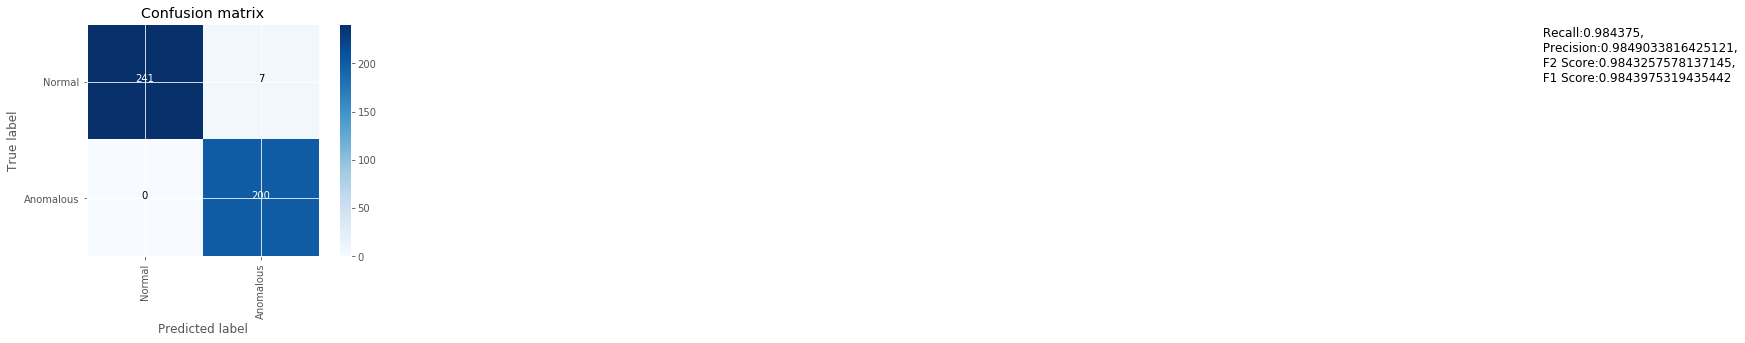

In [32]:
plot_confusion_matrix(cm, classes=['Normal','Anomalous'],
                      recall=recall,precision=precision,f2 = f2,f1=f1, title='Confusion matrix')

In [33]:
new_data = anomaly_data
new_data['anomalous'] = y_predict
normal_data = new_data[new_data['anomalous'] == 0]
anomalous_data = new_data[new_data['anomalous'] == 1]
normal_data.head()

,meanBytes,minBytes,maxBytes,medAbsDev,skewLength,kurtosisLength,q10,q20,q30,q40,...,kurtosisTBP,skewTBP,network_to,network_from,network_both,network_to_external,network_local,anonymous_source_destination,state,anomalous
0,167.535211,46,1074,35.582453,2.828830,6.599962,46.0,46.0,46.0,58.0,...,294.352427,16.653879,284,769,0,0,12,0,android_wan_watch,0
2,557.774849,46,1074,717.579474,0.006086,-1.864808,46.0,46.0,54.0,102.0,...,99.797854,8.426359,287,1029,12,0,0,0,android_lan_watch,0
4,451.009418,46,1074,38.547658,0.417756,-1.675003,46.0,46.0,46.0,54.0,...,71.564209,7.576815,308,846,14,0,0,0,android_lan_watch,0
5,151.687500,46,1074,35.582453,3.256768,9.958463,46.0,46.0,46.0,56.0,...,82.069233,6.932642,465,1034,0,0,5,0,android_wan_recording,0
7,143.101254,46,1074,35.582453,3.383325,10.350989,46.0,46.0,46.0,58.0,...,646.172005,23.207788,307,726,0,0,4,0,android_wan_watch,0


In [34]:
unknown_data = ss_knn.transform(normal_data.drop(['state','anomalous'], axis=1))
unknown_data = pca.transform(unknown_data)
unknown_data = pd.DataFrame(unknown_data)
unknown_data = unknown_data.iloc[:, :4]
y_predict = trained_model.predict(unknown_data)
y_predicted_1d = np.argmax(y_predict, axis=1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [35]:
normal_data['predictions'] = y_predicted_1d
anomalous_data['predictions'] = 8

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [36]:
final_data = normal_data.append(anomalous_data).sort_index()

In [37]:
y_test = final_data['state'].map(di)
y_predict = final_data['predictions']

In [38]:
recall = recall_score(y_pred=y_predict, y_true=y_test,average='weighted')
precision = precision_score(y_pred=y_predict, y_true=y_test,average='weighted')
f2 = fbeta_score(y_pred=y_predict, y_true=y_test,average='weighted',beta=2)
f1 = f1_score(y_pred=y_predict, y_true=y_test,average='weighted')

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
_acc_score = accuracy_score(y_test, y_predict)
_acc_score

0.9620535714285714

In [40]:
cm = confusion_matrix(y_test, y_predict)
print(cm)

[[ 44   3   0   0   0   0   0   0   1]
 [  4  31   0   0   0   0   0   0   1]
 [  0   0  32   0   0   0   0   0   0]
 [  2   0   0  43   0   0   0   0   0]
 [  0   0   0   0  34   0   0   0   0]
 [  0   0   0   1   0  47   0   0   0]
 [  0   0   0   0   0   0   0   0   4]
 [  0   0   0   0   0   0   0   0   1]
 [  0   0   0   0   0   0   0   0 200]]


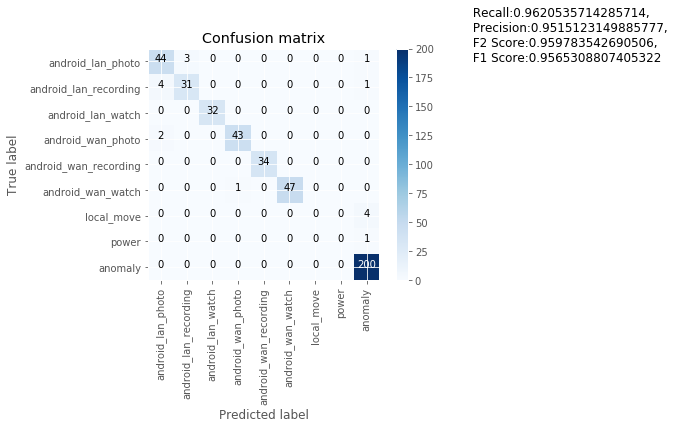

In [41]:
plot_confusion_matrix(cm, classes=list(di.keys()),
                      recall=recall,precision=precision,f2 = f2,f1=f1, title='Confusion matrix')

In [43]:
di['anomaly']

8